# TMS Timing Screen Screenshot Grabber


A simple script to grab a screenshot of a TSL Timing screen.

*Note that the recipe is easily generalised to grab arbitrary webpages.*

In [3]:
#Inspired by: https://www.kaggle.com/dierickx3/kaggle-web-scraping-via-headless-firefox-selenium
from webdriverdownloader import GeckoDriverDownloader
gdd = GeckoDriverDownloader()
geckodriver, geckobin = gdd.download_and_install("v0.23.0")

## Set up a browser instance

We can create a headless browser (one that doesnlt need to open in a window that we can see) that we can load pages into and grab screenshots from.

In [8]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

browser = webdriver.Firefox(executable_path=geckobin, options=options)


Set the URL of the page you want to grab the screenshot for:

In [19]:
url = "https://livetiming.tsl-timing.com/191231"
url = 'https://livetiming.tsl-timing.com/191209'

Some web pages take time to load. For example, the TSL live timing screens are likely to show a spinny thing when a timing screen page is first loaded.

*The TSL timing screen works by loading a page container, then sets up a data connection via a web socket to retrieve the actual timing updates. If we are just grabbing a screenshot of the rendered timing screen, we need to make sure we wait long enough for the spinny thing to disappear and for the table to be rendered.*

In [ ]:
#desiredId = 'tablebody' #The HTML id of a tag we want to be visible before we grab the page screenshot
undesiredId = 'loading' #The HTML tag of an element we want to be invisible before we grab the page screenshot

Set the name of the image file you want to save the screenshot to:

In [ ]:
outfile = 'screenshot.png'

Now we can grab the screenshot:

In [81]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


#Set a default screensize...
#There are other ways of setting up the browser so that we can grab the full browser view,
#even long pages that woould typically require scrollong to see completely
browser.set_window_size(800, 400)
browser.get(url)

#EC.visibility_of_element_located
#EC.presence_of_element_located
#EC.invisibility_of_element_located

#Let's wait for the spinny thing to disappear...
element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))

#Save the page
browser.save_screenshot( outfile )
print('screenshot saved to {}'.format(outfile))

screenshot saved to pageview.png


Preview the captured page:

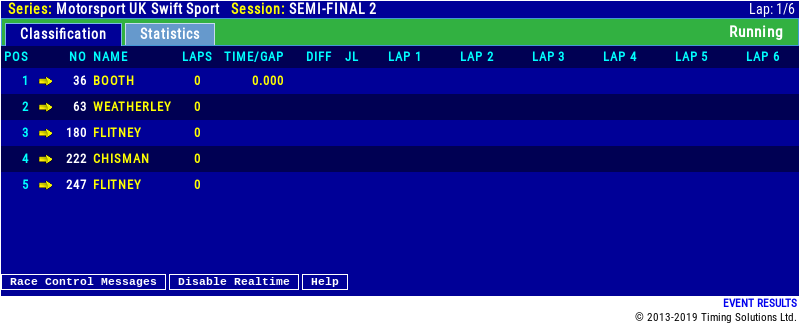

In [82]:
from IPython.display import Image
Image(outfile)

We can also grab other tabs...

screenshot saved to pageview_Classification.png


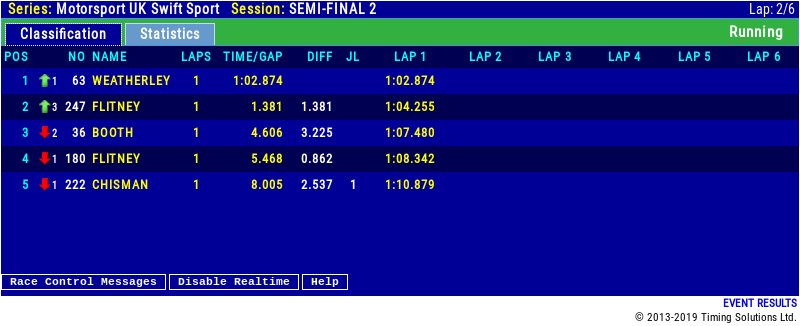

In [85]:
#Classification, Weather, Statistics

tabId = "Classification"
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

ofn = '{}_{}.png'.format(outfile.replace('.png',''),tabId)

#Save the page
browser.save_screenshot( ofn )
print('screenshot saved to {}'.format(ofn))
Image(ofn)

screenshot saved to pageview_Classification.png


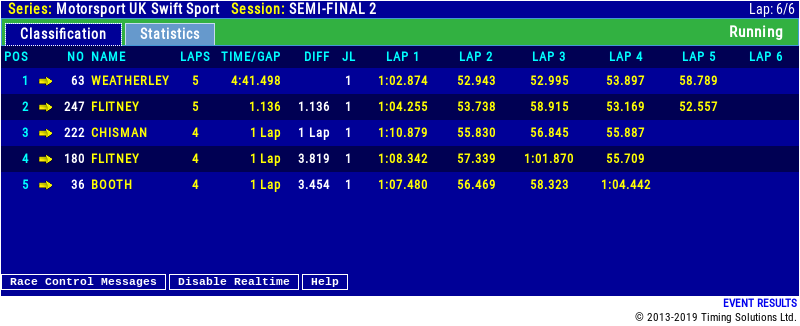

'pageview_Classification.png'

In [90]:
def getPageByTab(browser,url, tabId='Classification'):

    element = browser.find_element_by_id(tabId)
    element.click()
    element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

    ofn = '{}_{}.png'.format(outfile.replace('.png',''),tabId)

    #Save the page
    browser.save_screenshot( ofn )
    print('screenshot saved to {}'.format(ofn))
    display(Image(ofn))
    return ofn
    

url = 'https://livetiming.tsl-timing.com/191209'
getPageByTab(browser, url, 'Classification')

# Emailing the screenshot

Having grabbed the screenshot, we might now want to email it to somebody.

We can do that with the `smtplib` package if we have the details of an SMTP server we can connect to.

For example, if you have a GMail account:

In [44]:
import smtplib, ssl, getpass

port = 465  # For SSL

sender_email = input("Type your GMail address and press enter: ")
sender_password =  getpass.getpass()

# Create a secure SSL context
context = ssl.create_default_context()

receiver_email = "user@example.com"  # Enter receiver address
message = """\
Subject: Test

Test message from code..."""


with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, message)

Type your GMail address and press enter: *******@gmail.com
········


In [46]:
subject='Test email attachment'
text = """some text
Over several

lines"""


In [50]:
#https://stackoverflow.com/a/3363254/454773
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def send_mail(server, send_from, send_to, subject, text, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart()
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fo:
            part = MIMEApplication(
                fo.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()


    
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail(server, sender_email, [receiver_email], subject, text, files=[outfile])

Sending with image inline as HTML email:

In [51]:
cid = 0 #A unique id count for the image

#We'd probably need to rething this for multiple images...
htmltext=''''<html><body><h1>Timing screen</h1>\n<div><img src="cid:{cid}"></div>\n</body></html>'''.format(cid=cid)

In [76]:
import uuid, datetime
from email.mime.base import MIMEBase
from email import encoders

def add_image(msg, img, iid=0):
    uniqueId = '{}-{}-{}'.format(img.split('/')[-1], datetime.datetime.now().strftime('%Y%m%d%H%M%S'), uuid.uuid4())
    
    with open(outfile, 'rb') as f:
        # set attachment mime and file name, the image type is png
        mime = MIMEBase('image', 'png', filename=img)
        # add required header data:
        mime.add_header('Content-Disposition', 'attachment', filename=img)
        mime.add_header('X-Attachment-Id', str(iid))
        mime.add_header('Content-ID', '<{}>'.format(iid))
        # read attachment file content into the MIMEBase object
        mime.set_payload(f.read())
        # encode with base64
        encoders.encode_base64(mime)
        # add MIMEBase object to MIMEMultipart object
        msg.attach(mime)
    
def send_mail_html(server, send_from, send_to, subject, text, htmltext, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart('alternative')
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    fid=0
    for f in files or []:
        add_image(msg, f, fid)
        fid += 1
    msg.attach(MIMEText(htmltext, 'html', 'utf-8'))


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()
    


In [77]:
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail_html(server, sender_email, [receiver_email], subject, text, htmltext, files=[outfile])